<a href="https://colab.research.google.com/github/juyeeeeon/pytorch_newbie/blob/main/8_%EB%B9%84%EC%A7%80%EB%8F%84_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **8.1> 비지도 학습이란**

# **8.2> K-평균 알고리즘**

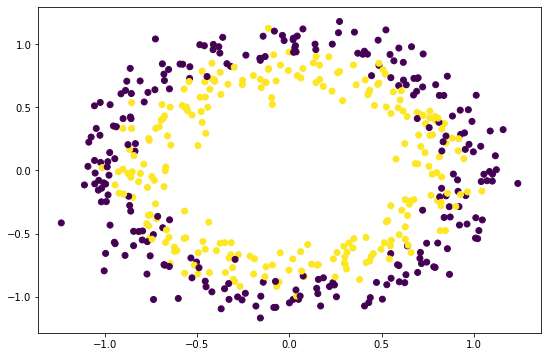

In [ ]:
# 데이터 만들기

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

x, y = make_circles(n_samples=500, noise=0.1)

plt.figure(figsize=(9,6))
plt.scatter(x[:, 0], x[:, 1], c=y)
plt.show()

In [ ]:
# 텐서 데이터 변환하기

x = torch.FloatTensor(x)
print(x.size())

torch.Size([500, 2])


In [ ]:
# K-평균 알고리즘

def l2distance(a, b):
    return torch.argmin(torch.sum((a-b)**2, dim=1), dim=0)

In [ ]:
def kmeans(x, num_clusters=2, max_iteration = 30):

    centroids = torch.rand(num_clusters, x.size(1))
    
    for update in range(max_iteration):
        y_assign = []
        for m in range(x.size(0)):
            h = x[m].expand(num_clusters,-1)
            assign = l2distance(h, centroids)
            y_assign.append(assign.item())

        y_assign = np.array(y_assign)
        if update != max_iteration-1:
            for i in range(num_clusters):
                idx = np.where(y_assign == i)[0]
                if len(idx) == 0:
                    centroids[i] = torch.rand(x.size(1))
                else:
                    centroids[i] = torch.mean(x[idx], dim=0)
    
    return y_assign, centroids

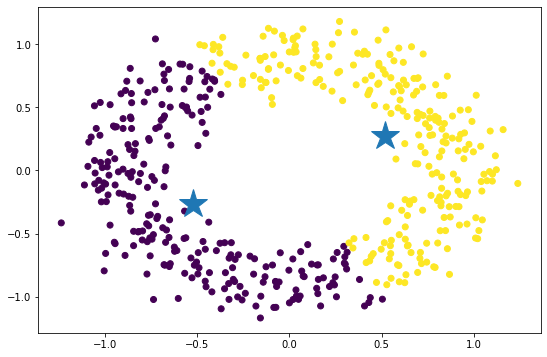

In [ ]:
# 알고리즘 실행 및 그래프 그리기

y_pred, centroids = kmeans(x,2)
plt.figure(figsize=(9,6))
plt.scatter(x[:,0], x[:,1], c=y_pred)
plt.plot(centroids[:,0], centroids[:,1], '*', markersize=30)
plt.show()

# **8.3> 오토인코더**

# **8.3.1) 스택 오토인코더**

In [ ]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [ ]:
dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset,batch_size=50,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
                        nn.Linear(784, 128), 
                        nn.ReLU(), 
                        nn.Linear(128, 32), 
                        nn.ReLU(), 
                        nn.Linear(32, 10), 
                        nn.ReLU())        
        self.decoder = nn.Sequential(
                        nn.Linear(10, 32),
                        nn.ReLU(),
                        nn.Linear(32, 128), 
                        nn.ReLU(), 
                        nn.Linear(128, 28*28) 
                        #nn.Sigmoid()
        )
    
    def forward(self, x):       
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = Autoencoder().to(device)

In [ ]:
def normalize_output(img):
    img = (img - img.min())/(img.max()-img.min())
    return img

def check_plot():
    with torch.no_grad():
        for data in trainloader:

            inputs = data[0].to(device)
            outputs = model(inputs.view(-1,28*28))
            outputs = outputs.view(-1,1,28,28)
            
            input_samples = inputs.permute(0,2,3,1).cpu().numpy() # 원래 이미지
            reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() # 생성 이미지
            
            break # 배치 하나만 받고 for문 종료

    #reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    #input_samples = normalize_output(input_samples) # 0~1사이로 변환

    columns = 10 # 시각화 전체 너비 
    rows = 5 # 시각화 전체 높이 

    fig=plt.figure(figsize=(columns, rows)) # figure 선언

    for i in range(1, columns*rows+1):
        img = input_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        plt.axis('off')
    plt.show()
    plt.close()

    fig=plt.figure(figsize=(columns, rows))

    for i in range(1, columns*rows+1):
        img = reconstructed_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        plt.axis('off')
    plt.show()

In [ ]:
criterion = nn.MSELoss() # MSE 사용
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
for epoch in range(51):

    running_loss = 0.0
    for data in trainloader:

        inputs = data[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs.view(-1,28*28))
        outputs = outputs.view(-1,1,28,28)
        loss = criterion(inputs, outputs) # 라벨 대신 입력 이미지와 출력 이미지를 비교

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    cost = running_loss / len(trainloader)        
    print('[%d] loss: %.3f' %(epoch + 1, cost))  


[1] loss: 0.057
[2] loss: 0.038
[3] loss: 0.036
[4] loss: 0.034
[5] loss: 0.033
[6] loss: 0.032
[7] loss: 0.031
[8] loss: 0.030
[9] loss: 0.030
[10] loss: 0.030
[11] loss: 0.029
[12] loss: 0.029
[13] loss: 0.029
[14] loss: 0.028
[15] loss: 0.028
[16] loss: 0.028
[17] loss: 0.028
[18] loss: 0.028
[19] loss: 0.027
[20] loss: 0.027
[21] loss: 0.027
[22] loss: 0.027
[23] loss: 0.027
[24] loss: 0.027
[25] loss: 0.027
[26] loss: 0.026
[27] loss: 0.026
[28] loss: 0.026
[29] loss: 0.026
[30] loss: 0.026
[31] loss: 0.026
[32] loss: 0.025
[33] loss: 0.025
[34] loss: 0.025
[35] loss: 0.025
[36] loss: 0.025
[37] loss: 0.025
[38] loss: 0.025
[39] loss: 0.025
[40] loss: 0.025
[41] loss: 0.025
[42] loss: 0.024
[43] loss: 0.024
[44] loss: 0.024
[45] loss: 0.024
[46] loss: 0.024
[47] loss: 0.024
[48] loss: 0.024
[49] loss: 0.024
[50] loss: 0.024
[51] loss: 0.024


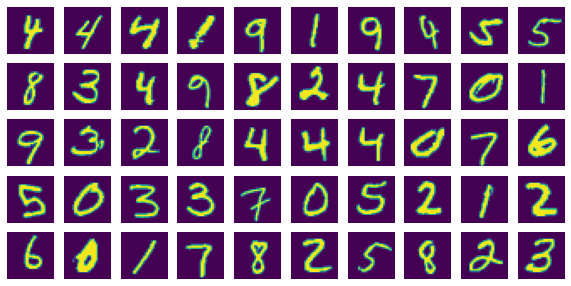

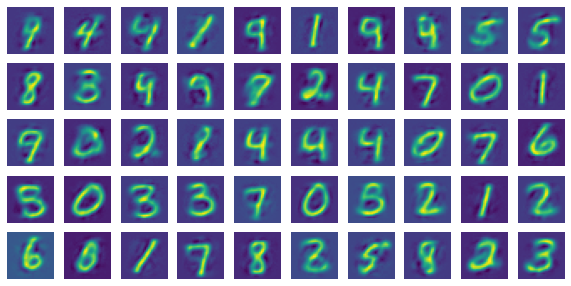

In [ ]:
check_plot()

# **8.3.2) 디노이징 오토인코더**


In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
                        nn.Linear(784, 128), 
                        nn.ReLU(), 
                        nn.Linear(128, 32), 
                        nn.ReLU(), 
                        nn.Linear(32, 10), 
                        nn.ReLU())        
        self.decoder = nn.Sequential(
                        nn.Linear(10, 32),
                        nn.ReLU(),
                        nn.Linear(32, 128), 
                        nn.ReLU(), 
                        nn.Linear(128, 28*28), 
                        nn.Sigmoid()
        )
        
    def forward(self, x):      
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
model = Autoencoder().to(device)

In [ ]:
def normalize_output(img):
    img = (img - img.min())/(img.max()-img.min())
    return img

def check_plot():
    with torch.no_grad():
        for data in trainloader:

            inputs = data[0].to(device)
            outputs = model(inputs.view(-1,28*28))
            outputs = outputs.view(-1,1,28,28)
            
            input_samples = inputs.permute(0,2,3,1).cpu().numpy() # 원래 이미지
            reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() # 생성 이미지
            
            break # 배치 하나만 받고 for문 종료

    #reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    #input_samples = normalize_output(input_samples) # 0~1사이로 변환

    columns = 10 # 시각화 전체 너비 
    rows = 5 # 시각화 전체 높이 

    fig=plt.figure(figsize=(columns, rows)) # figure 선언

    for i in range(1, columns*rows+1):
        img = input_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        plt.axis('off')
    plt.show()
    plt.close()

    fig=plt.figure(figsize=(columns, rows))

    for i in range(1, columns*rows+1):
        img = reconstructed_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        plt.axis('off')
    plt.show()

In [ ]:
criterion = nn.MSELoss() # MSE 사용
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
#학습하기

for epoch in range(51):

    running_loss = 0.0
    for data in trainloader:

        inputs = data[0].to(device)
        optimizer.zero_grad()
        dirty_inputs = inputs + torch.normal(0, 0.5, size=inputs.size()).to(device)
        outputs = model(dirty_inputs.view(-1,28*28))
        outputs = outputs.view(-1,1,28,28)
        loss = criterion(inputs, outputs) # 라벨 대신 입력 이미지와 출력 이미지를 비교

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    cost = running_loss / len(trainloader)        
    print('[%d] loss: %.3f' %(epoch + 1, cost))  


[1] loss: 0.082
[2] loss: 0.059
[3] loss: 0.052
[4] loss: 0.046
[5] loss: 0.043
[6] loss: 0.041
[7] loss: 0.040
[8] loss: 0.038
[9] loss: 0.038
[10] loss: 0.037
[11] loss: 0.036
[12] loss: 0.035
[13] loss: 0.035
[14] loss: 0.034
[15] loss: 0.034
[16] loss: 0.034
[17] loss: 0.033
[18] loss: 0.033
[19] loss: 0.033
[20] loss: 0.033
[21] loss: 0.032
[22] loss: 0.032
[23] loss: 0.032
[24] loss: 0.031
[25] loss: 0.031
[26] loss: 0.031
[27] loss: 0.031
[28] loss: 0.030
[29] loss: 0.030
[30] loss: 0.030
[31] loss: 0.030
[32] loss: 0.030
[33] loss: 0.030
[34] loss: 0.030
[35] loss: 0.030
[36] loss: 0.029
[37] loss: 0.029
[38] loss: 0.029
[39] loss: 0.029
[40] loss: 0.029
[41] loss: 0.029
[42] loss: 0.029
[43] loss: 0.029
[44] loss: 0.029
[45] loss: 0.029
[46] loss: 0.029
[47] loss: 0.029
[48] loss: 0.029
[49] loss: 0.029
[50] loss: 0.028
[51] loss: 0.028


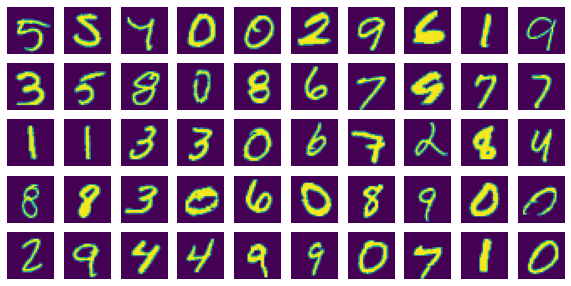

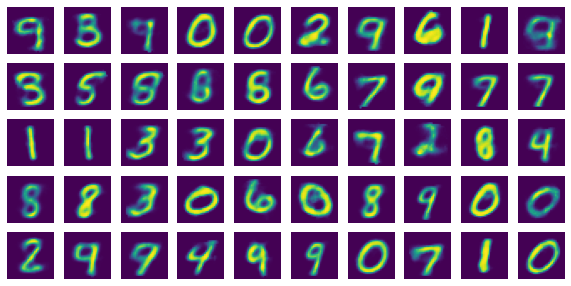

In [ ]:
check_plot()

# **8.3.3) 합성곱 오토인코더**

In [ ]:
#라이브러리 불러오기

import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F

import torch.nn as nn
import torch.optim as optim

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# GPU 연산 정의 및 MNIST 데이터 불러오기

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available')


cuda:0 is available


In [ ]:
dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=50, shuffle=True)

In [ ]:
# 모델 구축하기

class Flatten(torch.nn.Module): # 4D -> 2D로 계산하기
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1) # (배치 수, 채널 수, 이미지 너비, 이미지 높이) -> (배치 수, 채널 수*이미지 너비*이미지 높이)

class Deflatten(nn.Module): # 2D -> 4D로 계산하기

    def __init__(self, k):
        super(Deflatten, self).__init__()
        self.k = k
        
    def forward(self, x):
        s = x.size()
        
        # 벡터 사이즈 = 채널 수*이미지 너비*이미지 높이
        # 벡터 사이즈 = 채널 수*이미지 사이즈**2
        # 이미지 사이즈 = (벡터 사이즈//채널 수)**.5
        feature_size = int((s[1]//self.k)**.5) 
        
        return x.view(s[0],self.k,feature_size,feature_size) # (배치 수, 채널 수*이미지 너비*이미지 높이) -> (배치 수, 채널 수, 이미지 너비, 이미지 높이) 
    

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        k = 16
        self.encoder = nn.Sequential(
                        nn.Conv2d(1, k, 3, stride=2), 
                        nn.ReLU(), 
                        nn.Conv2d(k, 2*k, 3, stride=2),
                        nn.ReLU(), 
                        nn.Conv2d(2*k, 4*k, 3, stride=1),
                        nn.ReLU(),
                        Flatten(),
                        nn.Linear(1024, 10), 
                        nn.ReLU()
        )
        
        # ConvTranspose2d
        # 입력 성분(Conv의 결과)을 출력 성분(Conv의 입력)으로 미분하여 그 값을 입력 벡터와 곱해 출력 벡터를 산출한다.
        # 출력 된 벡터는 행렬 형태로 변환한다.
        self.decoder = nn.Sequential(
                        nn.Linear(10, 1024),
                        nn.ReLU(),
                        Deflatten(4*k),
                        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1), # (입력 채널 수, 출력 채널 수, 필터 크기, stride)
                        nn.ReLU(),
                        nn.ConvTranspose2d(2*k, k, 3, stride=2),
                        nn.ReLU(),
                        nn.ConvTranspose2d(k, 1, 3, stride=2,output_padding=1),
                        nn.Sigmoid()
        )
    
    def forward(self, x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [ ]:
# 모델, 손실 함수, 최적화 기법 정의하기

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
def normalize_output(img):
    img = (img - img.min())/(img.max()-img.min())
    return img

def check_plot():
    with torch.no_grad():
        for data in trainloader:

            inputs = data[0].to(device)
            outputs = model(inputs)
            
            input_samples = inputs.permute(0,2,3,1).cpu().numpy() # 원래 이미지
            reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() # 생성 이미지
            break # 배치 하나만 받고 for문 종료

    #reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    #input_samples = normalize_output(input_samples) # 0~1사이로 변환

    columns = 10 # 시각화 전체 너비 
    rows = 5 # 시각화 전체 높이 

    fig=plt.figure(figsize=(columns, rows)) # figure 선언

    # 원래 이미지 배치 크기 만큼 보여주기
    for i in range(1, columns*rows+1):
        img = input_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze()) # 1채널인 경우 2로 변환
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

    # 생성 이미지 배치 크기 만큼 보여주기
    fig=plt.figure(figsize=(columns, rows))

    for i in range(1, columns*rows+1):
        img = reconstructed_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

In [ ]:
# 학습하기

for epoch in range(51):
    running_loss = 0.0

    for data in trainloader:

        inputs = data[0].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(inputs, outputs)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    cost = running_loss / len(trainloader)
    
    if epoch%10 == 0:
        print('[%d] loss : %.3f' % (epoch+1, cost))

[1] loss : 0.134
[11] loss : 0.064
[21] loss : 0.056
[31] loss : 0.054
[41] loss : 0.053
[51] loss : 0.052


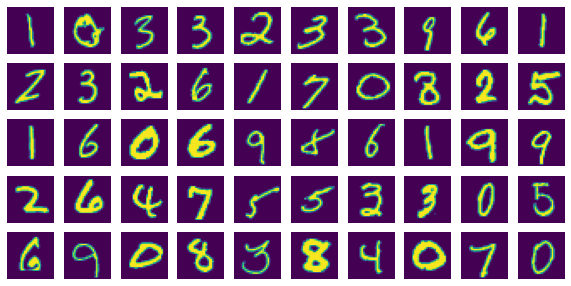

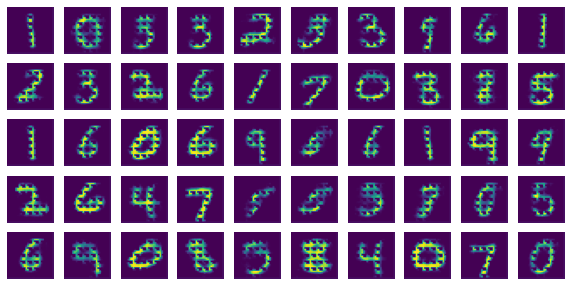

In [ ]:
check_plot()

# **8.4> 생성적 적대 신경망**

# **8.4.1) Vanila GAN**

In [ ]:
#라이브러리 불러오기

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.utils import make_grid
import imageio
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# 패션 아이템 데이터 불러오기

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])
trainset = FashionMNIST(root='./data/', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# 생성자 구축하기

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.n_out = 784
        self.linear = nn.Sequential(
            nn.Linear(self.n_features, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.view(-1, 1, 28, 28)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_in = 784
        self.n_out = 1
        self.linear = nn.Sequential(
                    nn.Linear(self.n_in, 1024),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(1024, 512),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(512, 256),
                    nn.LeakyReLU(0.2),
                    nn.Dropout(0.3),
                    nn.Linear(256, self.n_out),
                    nn.Sigmoid()
                    )
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear(x)
        return x

In [ ]:
# 모델 정의하기

generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
# 손실 함수 및 최적화 기법 정의하기

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []

images = []

criterion = nn.BCELoss()

In [ ]:
# 잠재 변수 및 라벨 정의하기

def noise(n, n_features=128):
    data = torch.randn(n, n_features)
    return data.to(device)

def label_ones(size):
    data = torch.ones(size, 1)
    return data.to(device)

def label_zeros(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [ ]:
# 구별자 학습 함수 정의하기

def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()

    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))

    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n))

    loss = d_loss + g_loss

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# 생성자 학습 함수 정의하기

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)

    optimizer.zero_grad()

    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# 모델 학습하기

test_noise = noise(64)
l = len(trainloader)

for epoch in range(151):
    g_loss = 0.0
    d_loss = 0.0

    for data in trainloader:
        imgs, _ = data
        n = len(imgs)
        z = noise(n)
        fake_data = generator(z).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(z)
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).detach().cpu()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)

    if epoch % 10 == 0:
        print('Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r'.format(epoch, g_loss/l, d_loss/l))

Epoch 0: g_loss: 3.326 d_loss: 0.592
Epoch 10: g_loss: 1.902 d_loss: 0.785
Epoch 20: g_loss: 1.466 d_loss: 0.926
Epoch 30: g_loss: 1.343 d_loss: 0.980
Epoch 40: g_loss: 1.216 d_loss: 1.047
Epoch 50: g_loss: 1.238 d_loss: 1.050
Epoch 60: g_loss: 1.222 d_loss: 1.063
Epoch 70: g_loss: 1.130 d_loss: 1.130
Epoch 80: g_loss: 1.128 d_loss: 1.129
Epoch 90: g_loss: 1.085 d_loss: 1.146
Epoch 100: g_loss: 1.081 d_loss: 1.171
Epoch 110: g_loss: 1.038 d_loss: 1.185
Epoch 120: g_loss: 1.033 d_loss: 1.189
Epoch 130: g_loss: 1.034 d_loss: 1.194
Epoch 140: g_loss: 1.000 d_loss: 1.211
Epoch 150: g_loss: 1.007 d_loss: 1.215


In [ ]:
# 모델 저장하기기

torch.save(discriminator.state_dict(), './models/fmnist_disc.pth') 
torch.save(generator.state_dict(), './models/fmnist_gner.pth')  

In [ ]:
# 검증 이미지 변화를 gif 파일로 저장하기

to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('fashion_items.gif', imgs)

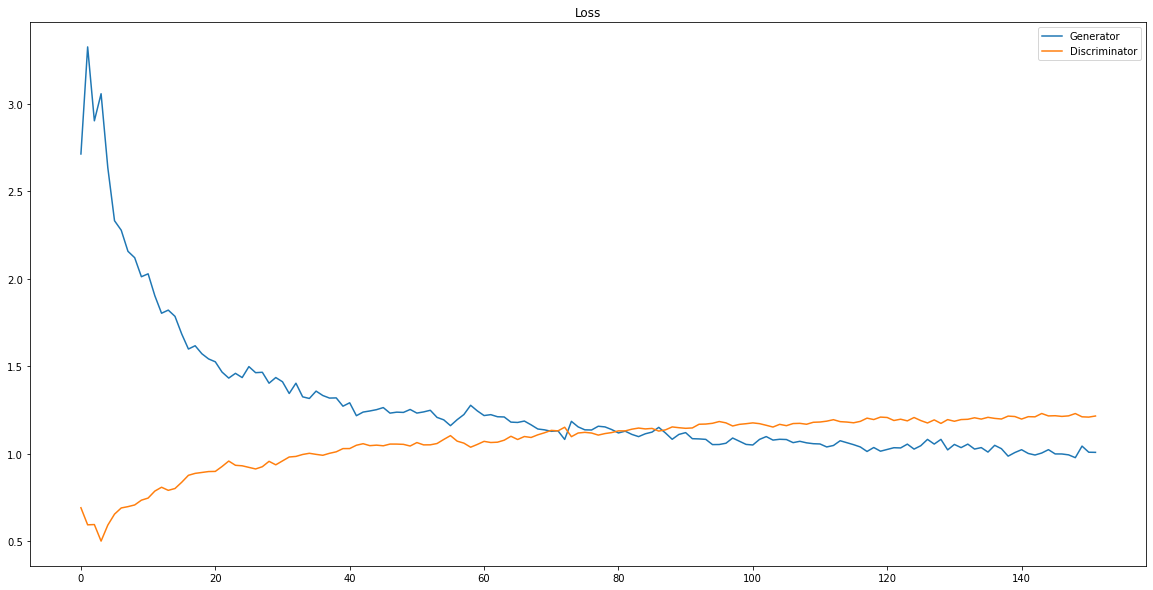

In [ ]:
# 손실 함수값 그래프 그리기

plt.figure(figsize = (20, 10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator', 'Discriminator'])
plt.title('Loss')
plt.savefig('gan_loss.png')

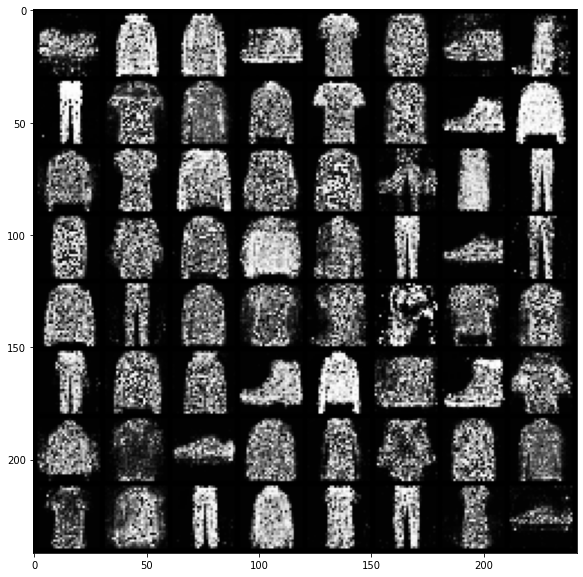

In [ ]:
test_noise = noise(64)
to_image = transforms.ToPILImage()
img = generator(test_noise).cpu().detach()
img = to_image(make_grid(img))
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

# **8.4.2) Deep Convolutional GAN(DCGAN)**

In [ ]:
# 생성자 구축하기

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_features = 128
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(self.n_features, 256, 3, 1, bias=False),
            nn.ReLU(True),           
            nn.ConvTranspose2d(256, 128, 3, 2, bias=False),
            nn.ReLU(True), 
            nn.ConvTranspose2d(128, 64, 3, 2, bias=False),
            nn.ReLU(True),   
            nn.ConvTranspose2d(64, 1, 2, 2, 1, bias=False),
            nn.Tanh())
           
    def forward(self, x):
        x = x.view(-1, self.n_features, 1, 1)
        x = self.conv(x)
        return x

# 구별자 구축하기

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv =  nn.Sequential(
                    nn.Conv2d(1, 128, 3, 2, 1, bias=False),
                    nn.LeakyReLU(0.2), 
                    nn.Dropout(0.5),        
                    nn.Conv2d(128, 256, 3, 2, 1, bias=False),
                    nn.LeakyReLU(0.2),     
                    nn.Dropout(0.5),
                    nn.Conv2d(256, 256, 3, 2, 1, bias=False),
                    nn.LeakyReLU(0.2, inplace=True),    
                    nn.Dropout(0.5),
                    nn.Conv2d(256, 1, 3, 2, bias=False), 
                    nn.Sigmoid())
        
    def forward(self, x):
        x = self.conv(x)
        return x.view(-1,1)

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

pretrained =  False
if pretrained == True:
    discriminator.load_state_dict(torch.load('./models/fmnist_disc_dcgan.pth'))
    generator.load_state_dict(torch.load('./models/fmnist_gner_dcgan.pth'))

g_optim = optim.Adam(generator.parameters(), lr=2e-4)
d_optim = optim.Adam(discriminator.parameters(), lr=2e-4)

g_losses = []
d_losses = []
images = []

criterion = nn.BCELoss()

def noise(n, n_features=128):
    data = torch.randn(n, n_features)
    return data.to(device)

def label_ones(size):
    data = torch.ones(size, 1)
    return data.to(device)

def label_zeros(size):
    data = torch.zeros(size, 1)
    return data.to(device)

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    n = real_data.size(0)

    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    d_loss = criterion(prediction_real, label_ones(n))

    prediction_fake = discriminator(fake_data)
    g_loss = criterion(prediction_fake, label_zeros(n))
    
    loss = d_loss + g_loss

    loss.backward()
    optimizer.step()
    
    return loss.item()

def train_generator(optimizer, fake_data):
    n = fake_data.size(0)
    optimizer.zero_grad()
    
    prediction = discriminator(fake_data)
    loss = criterion(prediction, label_ones(n))
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [ ]:
test_noise = noise(64)
l = len(trainloader)

for epoch in range(301):
    g_loss = 0.0
    d_loss = 0.0

    for data in trainloader:
        imgs, _ = data
        n = len(imgs)
        z = noise(n)
        fake_data = generator(z).detach()
        real_data = imgs.to(device)
        d_loss += train_discriminator(d_optim, real_data, fake_data)
        fake_data = generator(z)
        g_loss += train_generator(g_optim, fake_data)

    img = generator(test_noise).cpu().detach()
    img = make_grid(img)
    images.append(img)
    g_losses.append(g_loss/l)
    d_losses.append(d_loss/l)

    if epoch % 10 == 0:
        print('Epoch {}: g_loss: {:.3f} d_loss: {:.3f}\r'.format(epoch, g_loss/l, d_loss/l))
       
torch.save(discriminator.state_dict(), './models/fmnist_disc_dcgan.pth') 
torch.save(generator.state_dict(), './models/fmnist_gner_dcgan.pth')    

Epoch 0: g_loss: 0.903 d_loss: 0.753
Epoch 10: g_loss: 4.534 d_loss: 0.310
Epoch 20: g_loss: 4.463 d_loss: 0.352
Epoch 30: g_loss: 2.262 d_loss: 0.726
Epoch 40: g_loss: 1.692 d_loss: 0.922
Epoch 50: g_loss: 1.435 d_loss: 1.027
Epoch 60: g_loss: 1.303 d_loss: 1.077
Epoch 70: g_loss: 1.205 d_loss: 1.120
Epoch 80: g_loss: 1.137 d_loss: 1.151
Epoch 90: g_loss: 1.091 d_loss: 1.171
Epoch 100: g_loss: 1.082 d_loss: 1.189
Epoch 110: g_loss: 1.034 d_loss: 1.198
Epoch 120: g_loss: 1.020 d_loss: 1.214
Epoch 130: g_loss: 1.006 d_loss: 1.217
Epoch 140: g_loss: 0.991 d_loss: 1.226
Epoch 150: g_loss: 0.976 d_loss: 1.229
Epoch 160: g_loss: 0.973 d_loss: 1.235
Epoch 170: g_loss: 0.977 d_loss: 1.239
Epoch 180: g_loss: 0.949 d_loss: 1.243
Epoch 190: g_loss: 0.959 d_loss: 1.246
Epoch 200: g_loss: 0.933 d_loss: 1.252
Epoch 210: g_loss: 0.932 d_loss: 1.251
Epoch 220: g_loss: 0.935 d_loss: 1.256
Epoch 230: g_loss: 0.930 d_loss: 1.256
Epoch 240: g_loss: 0.915 d_loss: 1.257
Epoch 250: g_loss: 0.915 d_loss: 1.2

In [ ]:
to_image = transforms.ToPILImage()
imgs = [np.array(to_image(i)) for i in images]
imageio.mimsave('fashion_items_dc.gif', imgs)

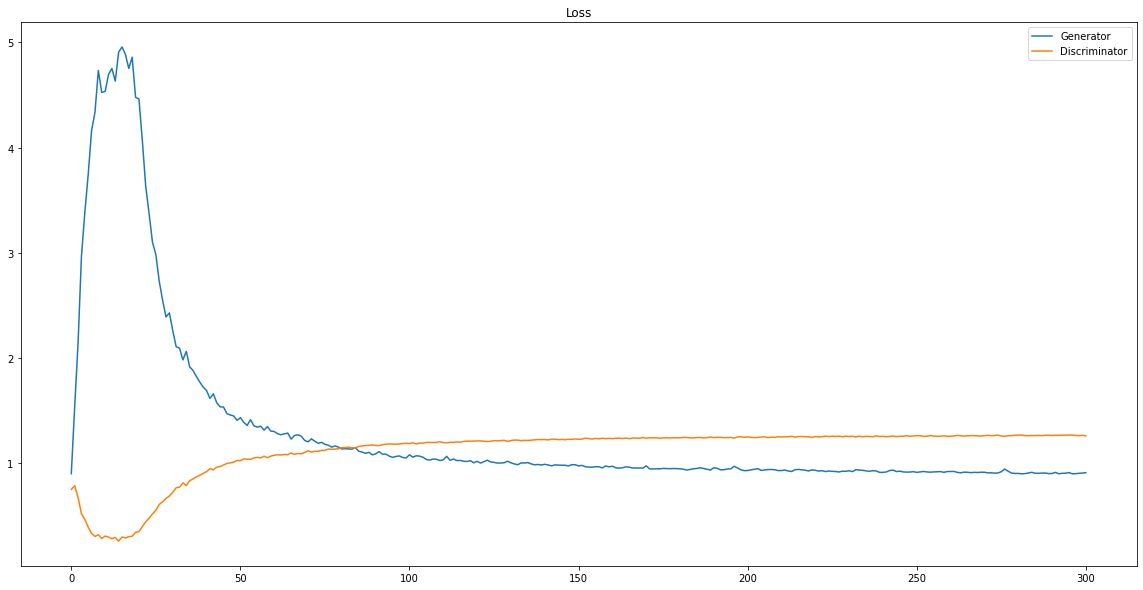

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Generator','Discriminator'])
plt.title('Loss')
plt.savefig('gan_loss.png')

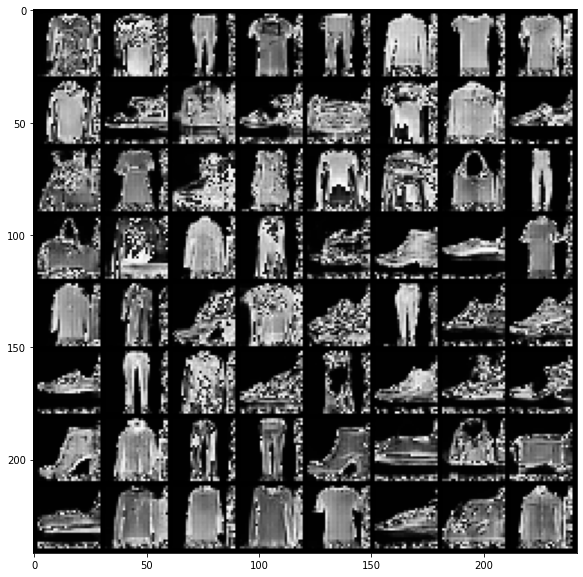

In [ ]:
test_noise = noise(64)
to_image = transforms.ToPILImage()
img = generator(test_noise).cpu().detach()
img = to_image(make_grid(img))
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

# **8.5> 이미지 스타일 변이**

In [ ]:
# 라이브러리 불러오기

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
#import copy

In [ ]:
# 모델 불러오기

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# 내용 손실 함수 정의하기

class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
# 스타일 손실 함수 정의하기

def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)  
    G = torch.mm(features, features.t())
    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# 정규화 함수 정의하기

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [ ]:
# 모델 재정의하기

def get_style_model_and_losses(cnn, style_img, content_img):

    #cnn = copy.deepcopy(cnn)
    content_layers = ['conv_4'] # 피쳐맵을 추출하려는 컨텐츠 레이어
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'] # 관심있는 스타일 레이어들
    normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device) # 정규화를 위한 평균 정의
    normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device) # 정규화를 위한 표준편차 정의
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    content_losses = [] # 컨텐츠 손실 함수 저장 리스트
    style_losses = [] # 스타일 손실 함수 저장 리스트

    model = nn.Sequential(normalization) # 입력값을 정규화한다.

    i = 0  
    for layer in cnn.children(): # 층 정보를 하나 씩 불러와 모델 구축
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'maxpool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers: # 원하는 컨텐츠 레이어에서 손실함수를 계산을 추가한다.
            target = model(content_img)
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers: # 원하는 스타일 레이어에서 손실함수를 계산을 추가한다.
            target_feature = model(style_img)
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1): # 모델을 뒤 부터 확인하여 가장 마지막 위치의 손실 함수를 확인한다.
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)] # 사용할 층까지만 잘라서 모델을 재정의

    return model, style_losses, content_losses

In [ ]:
# 결과 이미지 최적화하기

def run_style_transfer(cnn, content_img, style_img, num_steps=300, style_weight=100000, content_weight=1):

    input_img = content_img.clone().detach().requires_grad_(True)
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)
    optimizer = optim.LBFGS([input_img])
    iteration = [0]
    while iteration[0] <= num_steps:
        def closure():  
            input_img.data.clamp_(0, 1) # 0이상 1이하의 값만 사용한다.
            optimizer.zero_grad()
            model(input_img) # 손실 함수들이 들어가 재정의 된 모델이다.
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss # 각 레이어들의 손실 MSE 함수를 불러와 더한다.
            for cl in content_losses:
                content_score += cl.loss # 각 레이어들의 손실 MSE 함수를 불러와 더한다.

            loss = style_weight*style_score + content_weight*content_score # 가중치를 결합한 최종 손실 함수 정의
            loss.backward()

            iteration[0] += 1
            if iteration[0] % 50 == 0:
                print('Iteration {}: Style Loss : {:4f} Content Loss: {:4f}'.format(
                    iteration[0], style_score.item(), content_score.item()))

            return style_score + content_score

        optimizer.step(closure)

    return input_img.data.clamp_(0, 1)

In [ ]:
# 예제 이미지 불러오기

def image_loader(img_path):
    loader = transforms.Compose([transforms.Resize((256)), transforms.ToTensor()]) 
    image = Image.open(img_path).convert('RGB')   
    image = loader(image).unsqueeze(0) # 4차원 텐서 변환
    return image.to(device)

style_img = image_loader("./data/imgA.jpg")
content_img = image_loader("./data/imgB.jpg")

In [ ]:
# 이미지 학습하기

output = run_style_transfer(cnn, content_img, style_img)

<ipython-input-15-792b195d62c6>:9: UserWarning: Using a target size (torch.Size([1, 128, 128, 128])) that is different to the input size (torch.Size([1, 128, 128, 129])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.loss = F.mse_loss(input, self.target)


RuntimeError: ignored

In [ ]:
def imshow(image, title):
    unloader = transforms.ToPILImage()
    image = unloader(image.squeeze(0).cpu())
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
imshow(output, title='Output Image')

In [ ]:
imshow(content_img, title='Input Image')

In [ ]:
imshow(style_img, title='Style Image')

# **8.6> 깊은 K-평균 알고리즘**

In [2]:
# 라이브러리 불러오기

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import linear_sum_assignment as linear_assignment

from sklearn.manifold import TSNE

In [4]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [3]:
# 데이터 불러오기

batch_size = 128
num_clusters = 10
latent_size = 10

In [5]:
trainset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST('./data/', download=True, train=False, transform=transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
# 벡터화, 피쳐맵화 클래스 정의하기

class Flatten(torch.nn.Module): 
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1) 
    
class Deflatten(nn.Module): 
    def __init__(self, k):
        super(Deflatten, self).__init__()
        self.k = k
        
    def forward(self, x):
        s = x.size()
        feature_size = int((s[1]//self.k)**.5)       
        return x.view(s[0], self.k, feature_size, feature_size)

In [8]:
# k-평균 알고리즘 정의하기

class Kmeans(nn.Module): 
    def __init__(self, num_clusters, latent_size):
        super(Kmeans, self).__init__()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.num_clusters = num_clusters
        self.centroids = nn.Parameter(torch.rand((self.num_clusters, latent_size)).to(device))
    
    def argminl2distance(self, a, b):    
        return torch.argmin(torch.sum((a-b)**2,dim=1),dim=0)

    def forward(self, x):
        y_assign = []
        for m in range(x.size(0)):
            h = x[m].expand(self.num_clusters,-1)
            assign = self.argminl2distance(h, self.centroids)
            y_assign.append(assign.item())
        
        return y_assign, self.centroids[y_assign]

In [9]:
# 오토인코더 정의하기

class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        
        k = 16
        self.encoder = nn.Sequential(
                        nn.Conv2d(1, k, 3, stride=2), 
                        nn.ReLU(), 
                        nn.Conv2d(k, 2*k, 3, stride=2),
                        nn.ReLU(), 
                        nn.Conv2d(2*k, 4*k, 3, stride=1),
                        nn.ReLU(),
                        Flatten(),
                        nn.Linear(1024, latent_size), 
                        nn.ReLU()
        )

    def forward(self, x):       
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        
        k = 16
        self.decoder = nn.Sequential(
                        nn.Linear(latent_size, 1024),
                        nn.ReLU(),
                        Deflatten(4*k),
                        nn.ConvTranspose2d(4*k, 2*k, 3, stride=1), # (입력 채널 수, 출력 채널 수, 필터 크기, stride)
                        nn.ReLU(),
                        nn.ConvTranspose2d(2*k, k, 3, stride=2),
                        nn.ReLU(),
                        nn.ConvTranspose2d(k, 1, 3, stride=2,output_padding=1),
                        nn.Sigmoid()
        )
    
    def forward(self, x):       
        return self.decoder(x)

In [10]:
# 클러스터 라벨 재배치 함수 정의하기

def cluster_acc(y_true, y_pred):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_assignment(w.max() - w)
    
    return sum([w[i, j] for i, j in zip(ind[0], ind[1])]) * 1.0 / y_pred.size

In [11]:
# 평가 함수 정의하기

def evaluation(testloader, encoder, kmeans, device):
    predictions = []
    actual = []

    with torch.no_grad():
        for images, labels in testloader: 
            inputs = images.to(device)
            labels = labels.to(device)
            latent_var = encoder(inputs)
            y_pred, _ = kmeans(latent_var)
            
            predictions += y_pred
            actual += labels.cpu().tolist()
            
    return cluster_acc(actual, predictions)

In [12]:
# 손실 함수 및 최적화 방법 정의하기

encoder = Encoder(latent_size).to(device)
decoder = Decoder(latent_size).to(device)
kmeans = Kmeans(num_clusters, latent_size).to(device)

In [13]:
# Loss and optimizer
criterion1 = torch.nn.MSELoss()
criterion2 = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(encoder.parameters()) + 
                              list(decoder.parameters()) +
                              list(kmeans.parameters()), lr=1e-3)

In [14]:
# 모델 학습 변수 설정하기

T1 = 50
T2 = 200
lam = 1e-3
ls = 0.05

In [16]:
# 모델 학습하기

for ep in range(300):
    if (ep > T1) and (ep < T2):
        alpha = lam*(ep - T1)/(T2 - T1) # 1/100, 2/100, .., 99/100
    elif ep >= T2:    
        alpha = lam
    else:
        alpha = lam/(T2 - T1)
        
    running_loss = 0.0
    for images, _ in trainloader:
        inputs = images.to(device)
        optimizer.zero_grad()
        latent_var = encoder(inputs)
        _, centroids = kmeans(latent_var.detach())
        outputs = decoder(latent_var)
        
        l_rec = criterion1(inputs, outputs) 
        l_clt = criterion2(latent_var, centroids) 
        loss = l_rec + alpha*l_clt
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
  
    avg_loss = running_loss / len(trainloader)        
    
    if ep % 10 == 0:               
        testacc = evaluation(testloader, encoder, kmeans, device)
        print('[%d] Train loss: %.4f, Test Accuracy: %.3f' %(ep, avg_loss, testacc))  
        
    if avg_loss < ls:
        ls = avg_loss
        torch.save(encoder.state_dict(),'./models/dkm_en.pth')
        torch.save(decoder.state_dict(),'./models/dkm_de.pth')
        torch.save(kmeans.state_dict(),'./models/dkm_clt.pth')

[0] Train loss: 0.0367, Test Accuracy: 0.114
[10] Train loss: 0.0258, Test Accuracy: 0.116
[20] Train loss: 0.0241, Test Accuracy: 0.176
[30] Train loss: 0.0233, Test Accuracy: 0.254
[40] Train loss: 0.0228, Test Accuracy: 0.271
[50] Train loss: 0.0224, Test Accuracy: 0.356
[60] Train loss: 0.0223, Test Accuracy: 0.500
[70] Train loss: 0.0220, Test Accuracy: 0.659
[80] Train loss: 0.0218, Test Accuracy: 0.762
[90] Train loss: 0.0217, Test Accuracy: 0.732
[100] Train loss: 0.0216, Test Accuracy: 0.736
[110] Train loss: 0.0215, Test Accuracy: 0.739
[120] Train loss: 0.0214, Test Accuracy: 0.738
[130] Train loss: 0.0213, Test Accuracy: 0.745
[140] Train loss: 0.0212, Test Accuracy: 0.750
[150] Train loss: 0.0211, Test Accuracy: 0.748
[160] Train loss: 0.0211, Test Accuracy: 0.750
[170] Train loss: 0.0210, Test Accuracy: 0.751
[180] Train loss: 0.0210, Test Accuracy: 0.753
[190] Train loss: 0.0209, Test Accuracy: 0.754
[200] Train loss: 0.0209, Test Accuracy: 0.756
[210] Train loss: 0.0208

In [17]:
# 최종 모델 평가하기

predictions = []
actual = []
latent_features = []
with torch.no_grad():
    for images, labels in testloader: 
        inputs = images.to(device)
        labels = labels.to(device)
        latent_var = encoder(inputs)
        y_pred, _ = kmeans(latent_var)
        
        predictions += y_pred
        latent_features += latent_var.cpu().tolist()
        actual += labels.cpu().tolist()
            
print(cluster_acc(actual, predictions))

0.7594


In [18]:
# 시각화 예시
# MNIST 실제 이밎와 생성 이미지 비교

encoder.load_state_dict(torch.load('./models/dkm_en.pth'))
decoder.load_state_dict(torch.load('./models/dkm_de.pth'))
kmeans.load_state_dict(torch.load('./models/dkm_clt.pth'))

<All keys matched successfully>

Input images


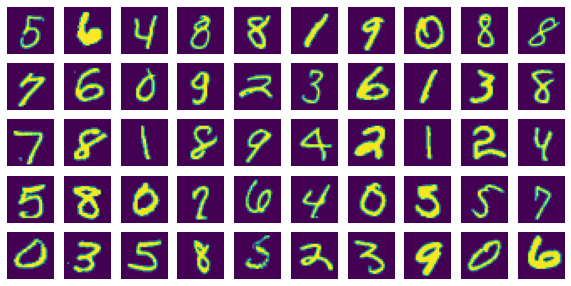

Reconstruction images


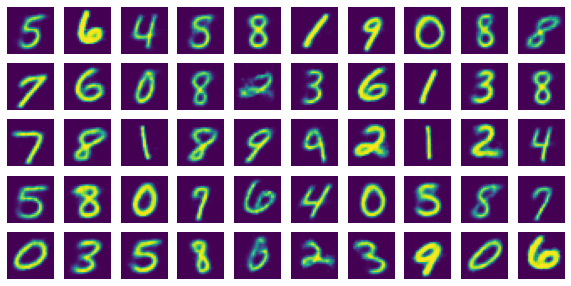

In [19]:
with torch.no_grad():
    for images, _ in testloader: 
        inputs = images.to(device)
        latent_var = encoder(inputs)
        outputs = decoder(latent_var)
        
        input_samples = inputs.permute(0,2,3,1).cpu().numpy()
        reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy()
        break

columns = 10
rows = 5
print("Input images")  
fig=plt.figure(figsize=(columns, rows))
for i in range(1, columns*rows+1):
    img = input_samples[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.axis('off')
plt.show()

print("Reconstruction images") 
fig=plt.figure(figsize=(columns, rows))
for i in range(1, columns*rows+1):
    img = reconstructed_samples[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
    plt.axis('off')  
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


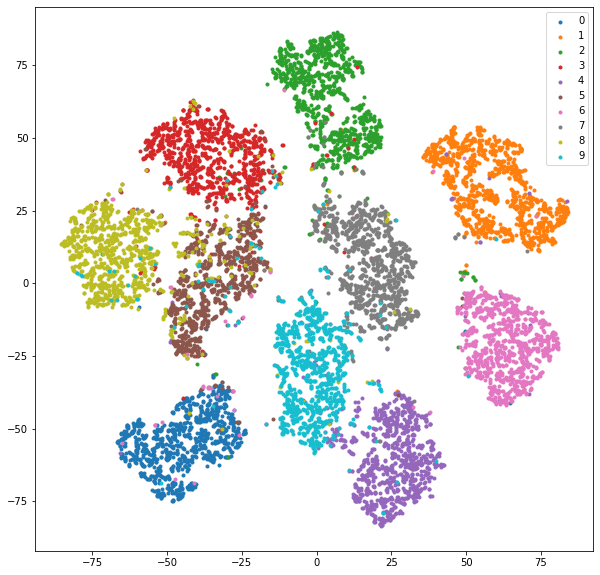

In [20]:
# t-SNE(10.2절)를 이용하여 나타낸 비지도 학습 모델이 예측한 결과

tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(latent_features)))
actual = np.array(actual)

plt.figure(figsize=(10, 10))
mnist = range(10)
for i, label in zip(range(10), mnist):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=str(label))
plt.legend()
plt.show()